In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.optimizers import *
from keras.datasets import mnist
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import pprint
pp = pprint.PrettyPrinter(indent=4)

Using TensorFlow backend.


## Load Dataset

In [2]:
pred_range=30

In [4]:
split_date='2018-07-05'
# Get normalized market_info
market_info=pd.read_csv("market_info.csv").iloc[:, 1:]

training_set, test_set = market_info[market_info['Date']<split_date], market_info[market_info['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

window_len = 35

LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)   

LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set)
    
LSTM_training_outputs = []

for i in range(window_len, len(training_set['btc_Close'])-pred_range):
    LSTM_training_outputs.append(training_set['btc_Close'][i:i+pred_range].values)
    
LSTM_training_outputs = np.array(LSTM_training_outputs)

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

## Model Definition

In [16]:
import keras
# %load models/lstm_model.py
"""
    If network is overfitting => decrease batch size; the contrary is true for underfitting
"""
def lstm_model(neurons, optimizer, loss, activ_func, dropout): 
    keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(35,13)))
    model.add(Dropout(dropout))
    # Units is the length of output vector, which in turn is the pred_range
    model.add(Dense(units=30))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

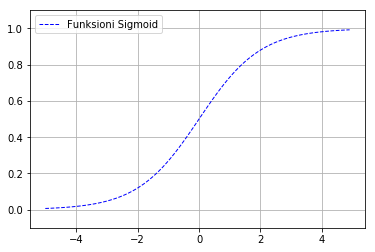

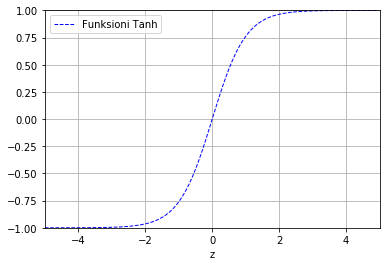

In [23]:
import numpy as np
import matplotlib.pylab as plt


def step(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

fig1 = plt.figure()
x = np.arange(-5.0, 5.0, 0.1)
y_step = step(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)
ax1 = fig1.add_subplot(111)
ax1.grid(True)
# plt.plot(x, y_step, label='Step', color='k', lw=1, linestyle=None)
plt.plot(x, y_sigmoid, label='Funksioni Sigmoid', color='b', lw=1, ls='--')
# plt.plot(x, y_relu, label='ReLU', color='k', lw=1, linestyle='-.')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

"""
tanh
~~~~
Plots a graph of the tanh function."""

import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-5, 5, .1)
t = np.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t, label='Funksioni Tanh',  color='b',lw=1, ls='--')
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
plt.legend()

plt.show()

In [22]:
from keras import optimizers
print(optimizers.SGD)

<class 'keras.optimizers.SGD'>


## Define the Parameters

In [17]:
batch_size = [20, 50, 100][:1]
epochs = [20, 50, 100][:1]
neurons = [10, 20, 30, 50][:1]
optimizer = ['adagrad','adam', 'adadelta', 'rmsprop'][:1]
loss=['mae','mean_squared_error']
activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'][:1]
dropout_rate = [0.3, 0.25, 0.8][:1]

## Model Wrapper and GridSearchCV

In [20]:
# Create the wrapper and pass params to GridSearchCV
params = dict(neurons = neurons,
              optimizer = optimizer,
              loss = loss,
              activ_func = activation,
              dropout = dropout_rate)
seed = 7

estimator = KerasRegressor(build_fn=lstm_model,  verbose=1, shuffle=True, batch_size = 100,
                        epochs = 50)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, LSTM_training_inputs[:-pred_range], LSTM_training_outputs, cv=kfold)

print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs)

prediction = estimator.predict(LSTM_test_inputs[:-pred_range])

models = GridSearchCV(estimator = model, param_grid=params,scoring = 'neg_mean_squared_error', n_jobs=1)

TypeError: lstm_model() missing 5 required positional arguments: 'neurons', 'optimizer', 'loss', 'activ_func', and 'dropout'

In [11]:
print(len(LSTM_training_inputs[:-pred_range]))
print(len(LSTM_training_outputs))



seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, train_x, train_y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(train_x, train_y)
prediction = estimator.predict(test_x)

1581
1581


## Train the Models

In [12]:
best_model = models.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs)
print('Best model :')
pp.pprint(best_model.best_params_)

Epoch 1/50
 - 1s - loss: 0.0855
Epoch 2/50
 - 0s - loss: 0.0410
Epoch 3/50
 - 0s - loss: 0.0315
Epoch 4/50
 - 0s - loss: 0.0262
Epoch 5/50
 - 0s - loss: 0.0225
Epoch 6/50
 - 0s - loss: 0.0203
Epoch 7/50
 - 0s - loss: 0.0186
Epoch 8/50
 - 0s - loss: 0.0178
Epoch 9/50
 - 0s - loss: 0.0174
Epoch 10/50
 - 1s - loss: 0.0172
Epoch 11/50
 - 0s - loss: 0.0168
Epoch 12/50
 - 0s - loss: 0.0165
Epoch 13/50
 - 0s - loss: 0.0163
Epoch 14/50
 - 0s - loss: 0.0162
Epoch 15/50
 - 0s - loss: 0.0160
Epoch 16/50
 - 0s - loss: 0.0159
Epoch 17/50
 - 0s - loss: 0.0158
Epoch 18/50
 - 0s - loss: 0.0159
Epoch 19/50
 - 0s - loss: 0.0159
Epoch 20/50
 - 0s - loss: 0.0158
Epoch 21/50
 - 0s - loss: 0.0157
Epoch 22/50
 - 0s - loss: 0.0157
Epoch 23/50
 - 0s - loss: 0.0156
Epoch 24/50
 - 0s - loss: 0.0156
Epoch 25/50
 - 0s - loss: 0.0156
Epoch 26/50
 - 0s - loss: 0.0155
Epoch 27/50
 - 1s - loss: 0.0155
Epoch 28/50
 - 0s - loss: 0.0156
Epoch 29/50
 - 0s - loss: 0.0155
Epoch 30/50
 - 0s - loss: 0.0156
Epoch 31/50
 - 0s -

 - 0s - loss: 0.0561
Epoch 50/50
 - 0s - loss: 0.0562
Epoch 1/50
 - 0s - loss: 0.0981
Epoch 2/50
 - 0s - loss: 0.0788
Epoch 3/50
 - 0s - loss: 0.0718
Epoch 4/50
 - 0s - loss: 0.0687
Epoch 5/50
 - 0s - loss: 0.0666
Epoch 6/50
 - 0s - loss: 0.0650
Epoch 7/50
 - 0s - loss: 0.0628
Epoch 8/50
 - 0s - loss: 0.0618
Epoch 9/50
 - 0s - loss: 0.0611
Epoch 10/50
 - 0s - loss: 0.0607
Epoch 11/50
 - 0s - loss: 0.0594
Epoch 12/50
 - 0s - loss: 0.0590
Epoch 13/50
 - 0s - loss: 0.0583
Epoch 14/50
 - 0s - loss: 0.0580
Epoch 15/50
 - 0s - loss: 0.0578
Epoch 16/50
 - 0s - loss: 0.0577
Epoch 17/50
 - 0s - loss: 0.0571
Epoch 18/50
 - 0s - loss: 0.0568
Epoch 19/50
 - 0s - loss: 0.0567
Epoch 20/50
 - 0s - loss: 0.0568
Epoch 21/50
 - 0s - loss: 0.0564
Epoch 22/50
 - 0s - loss: 0.0560
Epoch 23/50
 - 0s - loss: 0.0562
Epoch 24/50
 - 0s - loss: 0.0560
Epoch 25/50
 - 0s - loss: 0.0554
Epoch 26/50
 - 0s - loss: 0.0558
Epoch 27/50
 - 0s - loss: 0.0557
Epoch 28/50
 - 0s - loss: 0.0553
Epoch 29/50
 - 0s - loss: 0.055

In [19]:
pp.pprint(best_model)

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f55f92a3518>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'neurons': [10], 'optimizer': ['adagrad'], 'loss': ['mae', 'mean_squared_error'], 'activ_func': ['relu'], 'dropout': [0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)
